In [1]:
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy as cvx
import time
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
#plt.rcParams['figure.figsize'] = (14,14)
from IPython.core.pylabtools import figsize
figsize(14,8)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)
    
libs_path = '/Users/richard.wuebker/Projects/backtesting/libs'
if libs_path not in sys.path:
    sys.path.append(libs_path)
    
from risk_model import RiskModelPCA
from optimal_holdings import OptimalHoldingsCVX
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [2]:
dl = DataLoader(prices_dir='../../price_data_utils/prices', info_dir='../../price_data_utils/info', 
                analysis_date_str='2019-08-08', cached_dir='../../price_data_utils/cached')
dl.load_data()

Prediction Date: 2019-08-12


In [3]:
data = dl.data
data.head()

,mkt_cap,beta,book_value,sector,eps,month_ago,year_ago,prev_date,analysis_date,trade_date,pred_date,volume
ticker,,,,,,,,,,,,
CSCO,229986631680,0.995519,36804000000,Technology,2.882,56.340000,44.558083,52.340000,53.160000,52.430000,51.540001,26093500.0
SITC,2533060352,0.844472,1499137000,Real Estate,1.043,13.500000,NaN,13.780000,14.030000,14.030000,13.920000,1101295.0
UAL,22748133376,1.223721,10320000000,Industrials,9.838,89.459999,85.660004,86.480003,87.629997,86.980003,84.709999,1419900.0
TROW,26297821184,1.069091,6579100000,Financial Services,7.945,109.820000,112.935532,107.040001,110.250000,108.650002,106.610001,1158300.0
ISRG,61556834304,1.269715,7265300000,Healthcare,10.129,528.270020,529.049988,505.359985,519.409973,515.500000,509.880005,461800.0


In [4]:
hp = HistoricalPrices(prices_dir='../../price_data_utils/prices', 
                      cached_dir='../../price_data_utils/cached',
                      date_str='2019-08-12')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [5]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,2018-10-29,28.670000,24.500000,28.000000,25.820000,30427500.0,25.820000,REZI
1,2018-10-30,25.000000,20.510000,24.799999,21.059999,8275000.0,21.059999,REZI
2,2018-10-31,22.510000,19.309999,21.219999,21.049999,8148700.0,21.049999,REZI
3,2018-11-01,23.730000,20.420000,20.879999,22.000000,10101600.0,22.000000,REZI
4,2018-11-02,23.969999,20.549999,22.000000,23.780001,8104600.0,23.780001,REZI


In [6]:
def transform_prices(df, end_date_str):
    prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')
    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=5)
    prices_temp.index = pd.to_datetime(prices_temp.index)
    prices = prices_temp.loc[start_date:end_date]
    return prices.dropna(axis=1)
new_p = transform_prices(prices, '2016-01-05')


In [7]:
# to make the index of data we have with sector the same as in returns and prices

sector_data = data['sector']
index_ = sector_data.index.intersection(new_p.columns)
sector_data = sector_data.loc[index_]
p = new_p.loc[:, index_].copy() # to use only the stocks that are in sector_data
sectors = sector_data.unique()

In [8]:
returns = p.pct_change().drop(p.index[0])
print(returns.shape)
print(sector_data.shape)
print(p.shape)

(1257, 753)
(753,)
(1258, 753)


In [9]:
p.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,WAT,NNN,IEX,BWA,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,16.319235,25.350000,50.676487,91.209999,692.690002,59.998005,28.536177,40.535263,70.415245,34.523262,...,77.790001,17.154980,33.694031,33.655529,43.528183,23.909542,14.824180,6.94250,151.752335,16.587673
2011-01-06,16.460661,25.750000,50.676487,89.559998,718.400024,62.723892,28.326279,40.797573,69.994743,34.397305,...,76.050003,16.839489,33.711502,33.333599,43.555824,23.958487,14.856651,6.83000,150.116272,16.470205
2011-01-07,16.476372,25.950001,50.264294,89.133331,735.150024,62.590939,28.334854,40.758999,70.200493,34.976746,...,75.209999,16.681742,33.589188,32.179237,43.472923,24.031902,14.669928,6.69375,148.875351,16.315643
2011-01-10,16.334949,26.200001,50.342079,90.526665,749.960022,62.932850,28.647541,41.268200,70.057358,35.111115,...,74.680000,16.497704,33.807583,32.703529,44.891319,24.553984,14.678050,6.90250,151.096298,16.290915
2011-01-11,16.405655,25.690001,50.715374,93.663330,751.900024,63.474232,29.354307,41.653954,72.347855,35.279057,...,76.300003,16.333384,33.982292,32.422997,45.572895,24.456089,14.507563,6.79875,152.874680,16.303284


In [10]:
rets = returns.loc[returns.index.year==2015,:]
print(rets.loc[:,['AAPL']].head())
print(rets.loc[:,['AAPL']].tail())
print(rets.shape)

ticker          AAPL
Date                
2015-01-02 -0.009512
2015-01-05 -0.028172
2015-01-06  0.000094
2015-01-07  0.014022
2015-01-08  0.038422
ticker          AAPL
Date                
2015-12-24 -0.005340
2015-12-28 -0.011201
2015-12-29  0.017974
2015-12-30 -0.013059
2015-12-31 -0.019195
(252, 753)


# Build the risk model with PCA

In [11]:
risk_model = RiskModelPCA(rets, 20)

<BarContainer object of 20 artists>

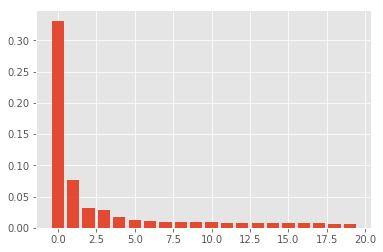

In [12]:
plt.bar(np.arange(risk_model.n_components), risk_model.pca.explained_variance_ratio_)

In [13]:
risk_model.factor_exposures.head()

,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,factor_11,factor_12,factor_13,factor_14,factor_15,factor_16,factor_17,factor_18,factor_19
ticker,,,,,,,,,,,,,,,,,,,,
CSCO,-0.036397,-0.018689,0.002916,0.040011,0.028939,-0.003978,0.024230,0.007624,-0.034777,0.000302,-0.022119,-0.021779,-0.014524,0.002253,-0.029282,0.013477,0.030499,0.013238,0.029146,-0.000955
UAL,-0.030869,-0.068295,0.020396,-0.022238,0.059176,-0.025018,-0.013220,0.036828,0.069571,0.208339,-0.001603,0.132176,-0.093027,0.111620,0.099320,-0.060992,0.027055,0.030927,0.068162,-0.055885
TROW,-0.035642,-0.003801,0.009313,0.033364,0.012146,0.015843,0.021703,-0.007359,0.035742,0.011440,-0.026776,-0.024407,-0.020758,0.021942,-0.000988,0.015465,-0.001598,-0.014963,0.019111,-0.002360
ISRG,-0.026729,-0.021654,-0.002175,-0.014659,-0.014905,-0.004293,-0.013224,-0.004206,-0.002176,-0.006327,0.002052,0.040926,-0.008251,-0.002644,0.038451,0.014302,0.007642,-0.014152,0.006641,0.050262
NVR,-0.020543,-0.024566,-0.006856,0.021186,-0.007462,-0.005053,-0.002737,-0.025587,0.011038,0.029133,0.046717,0.014395,-0.008098,0.016567,0.036258,-0.021735,-0.024643,0.014435,-0.063921,0.022534


In [14]:
risk_model.factor_returns.head()

,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,factor_11,factor_12,factor_13,factor_14,factor_15,factor_16,factor_17,factor_18,factor_19
Date,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.016455,0.036082,-0.118003,-0.053362,0.029346,0.061737,-0.017633,0.019019,0.045199,-0.014613,0.006680,0.005042,0.009473,0.044282,-0.093852,-0.007682,0.043943,0.016704,0.012588,-0.013997
2015-01-05,0.568426,-0.226452,-0.080494,-0.100610,0.013329,0.044615,-0.003859,0.023595,-0.037754,-0.060066,0.008952,-0.037938,-0.121788,0.013054,0.011709,-0.001582,0.003059,0.029159,0.004621,0.055447
2015-01-06,0.339041,-0.017107,-0.169204,0.027567,0.008775,0.022209,-0.033720,0.081981,-0.027593,0.000065,0.024737,-0.024374,-0.002785,0.031646,-0.008378,0.010458,0.047277,0.049226,-0.023475,0.033210
2015-01-07,-0.314386,-0.211454,-0.040387,-0.070539,-0.027379,-0.095143,-0.051454,-0.026023,-0.027624,-0.016423,0.026236,-0.063588,-0.017092,0.011973,0.043047,0.021402,0.000925,0.027245,-0.018369,0.020280
2015-01-08,-0.514639,-0.009376,0.032503,-0.022151,0.019518,-0.048362,0.037481,-0.035437,-0.037559,0.054889,0.046881,0.033521,0.045954,-0.020236,-0.010936,0.121882,0.018662,-0.004200,0.008765,-0.063056


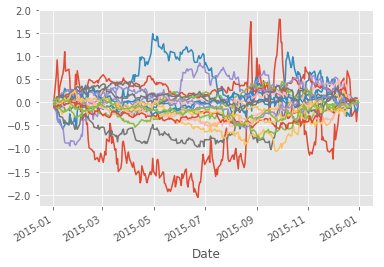

In [15]:
risk_model.factor_returns.cumsum().plot(legend=None)

In [16]:
risk_model.factor_cov_matrix

array([[18.79228599,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  4.34927959,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.81905486,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.62569433,  0.        ,
         0.        ,  0.        ,  0.        ,  

In [17]:
risk_model.i_var_matrix.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,WAT,NNN,IEX,BWA,LRCX,NUS,NWL,UAA,BLK,PPL
ticker,,,,,,,,,,,,,,,,,,,,,
CSCO,0.021232,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UAL,0.000000,0.035811,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TROW,0.000000,0.000000,0.007551,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISRG,0.000000,0.000000,0.000000,0.032087,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NVR,0.000000,0.000000,0.000000,0.000000,0.01628,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
risk_model.i_var_vector.head()

,0
ticker,
CSCO,0.021232
UAL,0.035811
TROW,0.007551
ISRG,0.032087
NVR,0.016280


In [19]:
initial_weights = pd.DataFrame(np.repeat(1/len(rets.columns), len(rets.columns)), rets.columns)
print(initial_weights.head())

print(risk_model.factor_exposures.shape)
print(risk_model.factor_cov_matrix.shape)
print(risk_model.i_var_matrix.shape)
print(initial_weights.shape)


risk_model.predict_portfolio_risk(initial_weights)

               0
ticker          
CSCO    0.001328
UAL     0.001328
TROW    0.001328
ISRG    0.001328
NVR     0.001328
(753, 20)
(20, 20)
(753, 753)
(753, 1)


array([[0.02332817]])

In [20]:
def create_momentum_factor(prices, sector_data):

    # demean by sector
    df = prices.pct_change(252).dropna()
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [21]:
momentum = create_momentum_factor(p, sector_data)
print(momentum.shape)
momentum.head()

(1006, 753)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,WAT,NNN,IEX,BWA,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-05,-0.432151,-1.328634,-0.252854,1.691824,-0.381580,1.586085,1.149337,0.740173,-1.209103,1.057390,...,-0.721784,0.133323,-0.137920,-0.974638,-1.016014,1.622864,-1.121753,1.227492,0.110336,-0.174699
2012-01-06,-0.441345,-1.379205,-0.206881,1.687227,-0.579266,1.526320,1.130948,0.763160,-1.273466,1.057390,...,-0.570071,0.188491,-0.160907,-1.006819,-0.979235,1.590683,-1.084974,1.291855,0.220673,-0.165505
2012-01-09,-0.468930,-1.448165,-0.285036,1.664240,-0.735576,1.517125,1.181519,0.763160,-1.149337,1.034403,...,-0.547085,0.285036,-0.133323,-0.947054,-0.956249,1.590683,-1.029806,1.347023,0.142518,0.036779
2012-01-10,-0.501111,-1.507930,-0.179297,1.645851,-0.901080,1.558501,1.144740,0.574669,-1.218297,1.048196,...,-0.579266,0.321814,-0.211478,-0.514903,-1.034403,1.517125,-1.084974,1.273466,0.096544,-0.018389
2012-01-11,-0.464332,-1.452762,-0.308022,1.650448,-0.882691,1.503333,1.094169,0.285036,-1.241284,1.034403,...,-0.579266,0.335606,-0.211478,-0.473527,-1.061988,1.512528,-0.997625,1.333231,0.110336,-0.133323


In [22]:
def create_mean_reversion_factor(window_length, prices, sector_data):
    sectors = sector_data.unique()
    df = prices.pct_change(window_length).dropna()
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first', ascending=False)
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [23]:
mean_reversion = create_mean_reversion_factor(5, p, sector_data)
print(mean_reversion.shape)
mean_reversion.head()

(1253, 753)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,WAT,NNN,IEX,BWA,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-12,0.225270,-0.376983,-1.029806,-0.786147,-1.701019,-1.287258,-0.850510,-1.250479,-0.781549,-1.071182,...,1.374607,1.595280,-0.395372,1.599877,-1.466554,-1.232089,0.220673,0.818328,-0.432151,0.753965
2011-01-13,0.514903,0.468930,-1.103364,-1.112558,-1.664240,0.767757,-1.043598,-0.671213,-0.790744,-0.827523,...,0.583863,1.438970,0.101142,1.659643,-1.521722,-1.305647,1.471152,-0.487319,-1.287258,1.549307
2011-01-14,1.039001,1.241284,-1.029806,-1.567696,-1.650448,0.243659,-0.905678,-0.836717,-0.914872,-0.606850,...,0.321814,1.324036,-0.510306,0.331009,-1.682630,-1.402191,1.328634,-1.370010,-1.287258,1.406789
2011-01-18,0.547085,1.645851,-1.061988,-1.595280,-1.599877,1.048196,-1.002222,-0.193089,-1.232089,-0.726381,...,-0.450540,0.905678,-0.556279,0.243659,-1.484944,0.262049,1.199908,-0.983833,-0.128726,1.512528
2011-01-19,0.859704,1.599877,-0.657421,-1.425178,-1.659643,0.565474,0.776952,0.193089,-0.514903,-1.034403,...,0.657421,0.496514,-0.468930,0.404567,-0.698797,-0.712589,1.176921,-0.960846,0.662018,1.342426


In [24]:
def create_smoothed_factor(factor, window=5):
    df = factor.rolling(window).mean().dropna()
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [25]:
smoothed_mean_reversion = create_smoothed_factor(mean_reversion, 5)
print(smoothed_mean_reversion.shape)
smoothed_mean_reversion.head()

(1249, 753)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,WAT,NNN,IEX,BWA,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-19,0.901080,1.227492,-1.264271,-1.535515,-1.710214,0.399969,-0.878094,-0.790744,-1.163129,-1.176921,...,0.698797,1.429776,-0.551682,1.144740,-1.576891,-1.190713,1.360815,-0.864302,-0.717186,1.544709
2011-01-20,0.956249,1.572293,-1.006819,-1.636656,-1.710214,0.294230,-0.514903,-0.344801,-1.190713,-0.983833,...,0.487319,1.314842,-0.225270,0.891886,-1.494138,-0.956249,1.563099,-1.011417,-0.482722,1.641254
2011-01-21,0.772355,1.673435,-0.616045,-1.678032,-1.627462,-0.482722,0.036779,-0.091947,-1.172324,-1.094169,...,0.197686,1.167727,-0.197686,0.409164,-1.310244,-0.505708,1.443568,-0.551682,0.114934,1.475749
2011-01-24,0.257452,1.691824,-0.202283,-1.668838,-1.209103,-0.970041,0.528695,0.358593,-1.287258,-1.181519,...,-0.229867,0.970041,0.078155,0.542487,-1.039001,0.220673,1.140143,0.303425,0.726381,1.222895
2011-01-25,-0.349399,1.641254,0.216075,-1.696422,-0.629837,-1.489541,1.061988,0.593058,-1.264271,-1.319439,...,-0.353996,0.730978,0.436748,0.818328,-0.970041,0.280438,0.868899,0.947054,0.514903,0.924067


In [26]:
smoothed_momentum = create_smoothed_factor(momentum, window=5)
print(smoothed_momentum.shape)
smoothed_momentum.head()

(1002, 753)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,WAT,NNN,IEX,BWA,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-11,-0.459735,-1.425178,-0.285036,1.664240,-0.694200,1.544709,1.144740,0.639031,-1.222895,1.052793,...,-0.588461,0.248257,-0.156310,-0.809133,-0.993027,1.572293,-1.052793,1.310244,0.137920,-0.110336
2012-01-12,-0.473527,-1.443568,-0.294230,1.650448,-0.836717,1.521722,1.144740,0.514903,-1.213700,1.043598,...,-0.560877,0.298828,-0.188491,-0.657421,-1.006819,1.563099,-1.034403,1.324036,0.151713,-0.101142
2012-01-13,-0.455138,-1.443568,-0.321814,1.645851,-0.896483,1.517125,1.149337,0.459735,-1.199908,1.029806,...,-0.556279,0.326412,-0.188491,-0.519500,-1.043598,1.544709,-1.029806,1.324036,0.119531,-0.050571
2012-01-17,-0.450540,-1.425178,-0.340204,1.645851,-0.956249,1.507930,1.140143,0.395372,-1.204505,1.006819,...,-0.528695,0.340204,-0.183894,-0.404567,-1.084974,1.526320,-1.048196,1.328634,0.110336,-0.045973
2012-01-18,-0.432151,-1.411386,-0.381580,1.641254,-0.970041,1.517125,1.135545,0.390775,-1.209103,0.988430,...,-0.528695,0.340204,-0.179297,-0.386177,-1.103364,1.535515,-1.043598,1.296452,0.137920,0.004597


In [27]:
index = smoothed_momentum.index.intersection(smoothed_mean_reversion.index)
m = momentum.loc[index,:].stack()
print(m.shape)
sm = smoothed_momentum.loc[index,:].stack()
print(sm.shape)
mr = mean_reversion.loc[index, :].stack()
print(mr.shape)
smr = smoothed_mean_reversion.loc[index, :].stack()
print(smr.shape)
adj_p = p.loc[index,:].copy()
print(adj_p.shape)

(754506,)
(754506,)
(754506,)
(754506,)
(1002, 753)


In [28]:
from collections import OrderedDict
factor_data = OrderedDict()
factor_data['momentum'] = al.utils.get_clean_factor_and_forward_returns(m, adj_p, periods=[1])
factor_data['smoothed_momentum'] = al.utils.get_clean_factor_and_forward_returns(sm, adj_p, periods=[1])
factor_data['mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(mr, adj_p, periods=[1])
factor_data['smoothed_mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(smr, adj_p, periods=[1])

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [29]:
factor_data['momentum'].head()

1D    factor  factor_quantile
date       asset                                     
2012-01-11 CSCO   0.004195 -0.464332                2
           UAL    0.028873 -1.452762                1
           TROW   0.000674 -0.308022                3
           ISRG   0.002582  1.650448                5
           NVR    0.000000 -0.882691                2

In [30]:
factor_returns_df = pd.DataFrame()
for key, val in factor_data.items():
    factor_returns_df[key] = al.performance.factor_returns(val).iloc[:,0]
factor_returns_df.head()

,momentum,smoothed_momentum,mean_reversion,smoothed_mean_reversion
date,,,,
2012-01-11,-0.001464,-0.001640,-0.001490,-0.000655
2012-01-12,0.003602,0.003564,0.000603,0.000595
2012-01-13,0.001710,0.001735,0.000762,0.000984
2012-01-17,-0.005278,-0.005213,-0.000124,-0.001924
2012-01-18,-0.004930,-0.004896,-0.000725,-0.000450


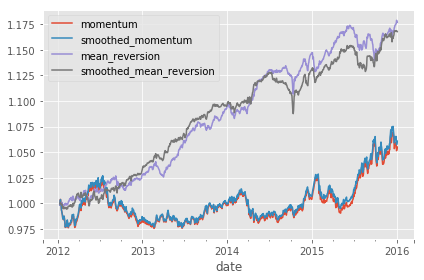

In [31]:
(1+factor_returns_df).cumprod().plot()
plt.tight_layout()

# Quantile Analysis

In [32]:
factor_names = factor_data.keys()
factor_names

odict_keys(['momentum', 'smoothed_momentum', 'mean_reversion', 'smoothed_mean_reversion'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f62a080>,
      dtype=object)

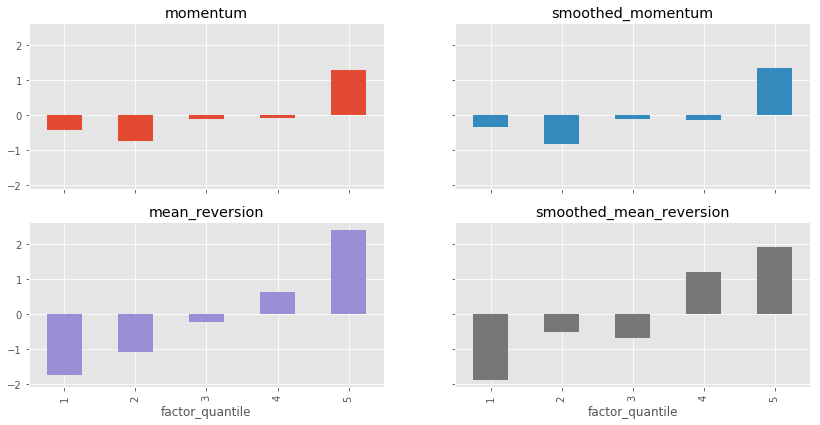

In [33]:
qr_factor_returns = pd.DataFrame()
for key, val in factor_data.items():
    qr_factor_returns[key] = al.performance.mean_return_by_quantile(val)[0].iloc[:,0]


(10000 * qr_factor_returns).plot.bar(
    subplots=True,
    sharey = True,
    layout=(4,2),
    figsize=(14,14),
    legend=False
)

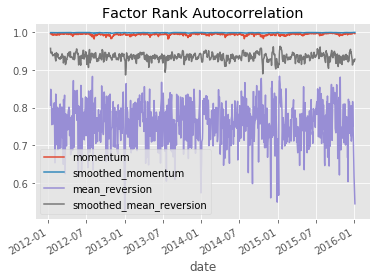

In [34]:
# Turnover analysis

fra_df = pd.DataFrame()

for key, val in factor_data.items():
    fra_df[key] = al.performance.factor_rank_autocorrelation(val)
    
fra_df.plot(title='Factor Rank Autocorrelation')

## sharpe ratio of the alphas

In [35]:
def get_sharpe_ratio(factor_returns, ann_factor):
    sharpe = factor_returns.mean() / (factor_returns.std())
    return sharpe * ann_factor

In [36]:
ann_factor = np.sqrt(252)
get_sharpe_ratio(factor_returns_df, ann_factor).round(2)

momentum                   0.44
smoothed_momentum          0.48
mean_reversion             1.92
smoothed_mean_reversion    1.84
dtype: float64

# The combined alpha vector

In [37]:
all_factors_df = pd.DataFrame()
for key, val in factor_data.items():
    all_factors_df[key] = val.loc[:,'factor']
all_factors_df.head()

momentum  smoothed_momentum  mean_reversion  \
date       asset                                                
2012-01-11 CSCO  -0.464332          -0.459735        1.314842   
           UAL   -1.452762          -1.425178        1.581488   
           TROW  -0.308022          -0.285036       -0.041376   
           ISRG   1.650448           1.664240        1.609072   
           NVR   -0.882691          -0.694200        0.436748   

                  smoothed_mean_reversion  
date       asset                           
2012-01-11 CSCO                 -0.367788  
           UAL                   1.678032  
           TROW                 -0.275841  
           ISRG                  1.301050  
           NVR                  -0.395372

In [38]:
selected_factors = ['smoothed_mean_reversion', 'mean_reversion']
all_factors_df['alpha_vector'] = all_factors_df[selected_factors].mean(axis=1)
alphas = all_factors_df[['alpha_vector']]
rets_index = rets.index[-1]
alpha_vector = alphas.loc[rets_index]
alpha_vector.head()

,alpha_vector
asset,
CSCO,-0.839016
UAL,0.533292
TROW,0.308022
ISRG,0.144816
NVR,0.726381


# Optimal Portfolio Constrained by Risk Model

In [44]:
class OptimalHoldingsCVX:

    def __init__(self, risk_model, alpha_vector, previous, risk_cap=0.05, factor_max=10.0, aum=50e6, lambda_reg=0.00,
                 factor_min=-10.0, weights_max=0.55, weights_min=-0.55, risk_aversion=1.0e-6):

        self.risk_model = risk_model
        self.alpha_vector = alpha_vector
        self.previous = previous
        self.risk_cap = risk_cap
        self.factor_min = factor_min 
        self.factor_max = factor_max
        self.weights_min = weights_min
        self.weights_max = weights_max
        self.risk_aversion = risk_aversion
        self.aum = aum
        self.lambda_reg = lambda_reg

    def _get_obj(self, h1):
        start = time.time()
        ra = self.risk_aversion
        Q = self.risk_model.Q # Q is k x N
        ivv = self.risk_model.i_var_vector
        av = -self.alpha_vector
        print(av)
        h0 = self.previous.flatten()
        lv = np.ones((len(av), 1)) * 0.1/2000000
        
        m = ra * 0.50
        #func = m * cvx.sum((Q @ h1)**2) + m * ((h1**2) @ ivv) - (h1 @ av) + ((h1-h0)**2) @ lv + self.lambda_reg * cvx.norm(h1, 2)
        #func = np.array(av.T) @ h1 #+ self.lambda_reg * cvx.norm(h1, 2) + ((h1-h0)**2) @ lv
        obj_func = cvx.Minimize(np.array(av.T) * h1 + self.lambda_reg * cvx.norm(h1, 2))
        #self.is_dcp = cvx.Problem(obj_func, []).is_dcp()
        #print(self.is_dcp)
        end = time.time()
        #print('get_obj took: ', end-start)
        print(obj_func)
        return obj_func

    def _get_constraints(self, h1, risk):
        start = time.time()
        c = []
        factor_exposures = self.risk_model.factor_exposures
        c.append(risk <= self.risk_cap**2)
        c.append(factor_exposures.T @ h1 <= self.factor_max)
        c.append(factor_exposures.T @ h1 >= self.factor_min)
        c.append(sum(h1) == 0)
        c.append(sum(cvx.abs(h1)) <= 1.0)
        c.append(h1 >= self.weights_min)
        c.append(h1 <= self.weights_max)
        
        print(c)
        end = time.time()
        print('get_constraints took: ', end-start)
        return c

    def get_risk(self, h1):
        start = time.time()
        ivv = self.risk_model.i_var_vector
        #result = cvx.sum((Q @ h1)**2) + (h1**2) @ ivv
        ivm = self.risk_model.i_var_matrix.values
        
        av_index = self.alpha_vector.index
        S = np.diag(self.risk_model.i_var_vector.loc[av_index].values.flatten())
        print('this is S:')
        print(S)
        f = self.risk_model.factor_exposures.loc[av_index].values.T @ h1
        X = self.risk_model.factor_cov_matrix
        
        end = time.time()
        #print('get_risk took: ', end-start)
        risk = cvx.quad_form(f, X) + cvx.quad_form(h1, S)
        print(risk)
        return risk

    def find(self):
        h1 = cvx.Variable(len(self.alpha_vector))
        risk = self.get_risk(h1)
        obj_func = self._get_obj(h1)
        constraints = self._get_constraints(h1, risk)
        prob = cvx.Problem(obj_func, constraints)
        start = time.time()
        #print(prob.is_dcp())
        #prob.solve(max_iters=100, verbose=True, solver=cvx.SCS)
        prob.solve(max_iters=100, verbose=True)
        
        optimal_weights = np.asarray(h1.value).flatten()
        df = pd.DataFrame(optimal_weights, index=self.alpha_vector.index)
        end = time.time()
        #print('find took: ', end-start)
        return df

In [45]:
oh = OptimalHoldingsCVX(risk_model, alpha_vector, initial_weights.values)
optimal_weights = oh.find()

this is S:
[[0.0212315  0.         0.         ... 0.         0.         0.        ]
 [0.         0.03581077 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00755124 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.03765301 0.         0.        ]
 [0.         0.         0.         ... 0.         0.01334663 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00886007]]
QuadForm([[-0.03639662 -0.030869   -0.03564221 ... -0.04069411 -0.04221971
  -0.02252618]
 [-0.01868864 -0.06829516 -0.00380112 ... -0.03005601 -0.0044745
  -0.01232065]
 [ 0.00291575  0.02039562  0.00931311 ...  0.00586831  0.00660069
  -0.09210928]
 ...
 [ 0.01323771  0.03092718 -0.01496277 ...  0.04470702 -0.02477886
  -0.0117992 ]
 [ 0.0291462   0.06816249  0.01911115 ...  0.02333025  0.02389723
  -0.01193544]
 [-0.00095548 -0.05588499 -0.0023602  ... -0.05513893 -0.028823
  -0.01284779]] * var25789, [[18.79228599  0.          0.      


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.573e-16  -2.640e+03  +1e+06  8e-01  1e+00  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -7.562e-01  -2.717e+02  +2e+05  5e-02  9e-01  2e-01  1e-01  0.9890  1e-01   1  1  1 |  0  0
 2  -5.043e+00  -4.074e+01  +2e+04  7e-03  3e-01  2e-02  2e-02  0.8774  2e-02   1  1  1 |  0  0
 3  -1.554e+00  -8.782e+00  +4e+03  1e-03  5e-02  4e-03  4e-03  0.9103  1e-01   1  1  1 |  0  0
 4  -1.430e+00  -3.598e+00  +1e+03  4e-04  2e-02  1e-03  1e-03  0.6795  5e-04   1  1  1 |  0  0
 5  -1.548e+00  -3.048e+00  +7e+02  3e-04  1e-02  8e-04  6e-04  0.9269  5e-01   1  1  1 |  0  0
 6  -1.640e+00  -2.112e+00  +2e+02  9e-05  4e-03  3e-04  2e-04  0.6973  2e-02   1  1  1 |  0  0
 7  -1.634e+00  -2.106e+00  +2e+02  9e-05  4e-03  3e-04  2e-04  0.0747  8e-01   2  2  2 |  0  0
 8  -1.632e+00  -2.107e+00  +2e+02  9e-05  4e-

In [46]:
risk_model.i_var_vector.sum()

0    21.871711
dtype: float64

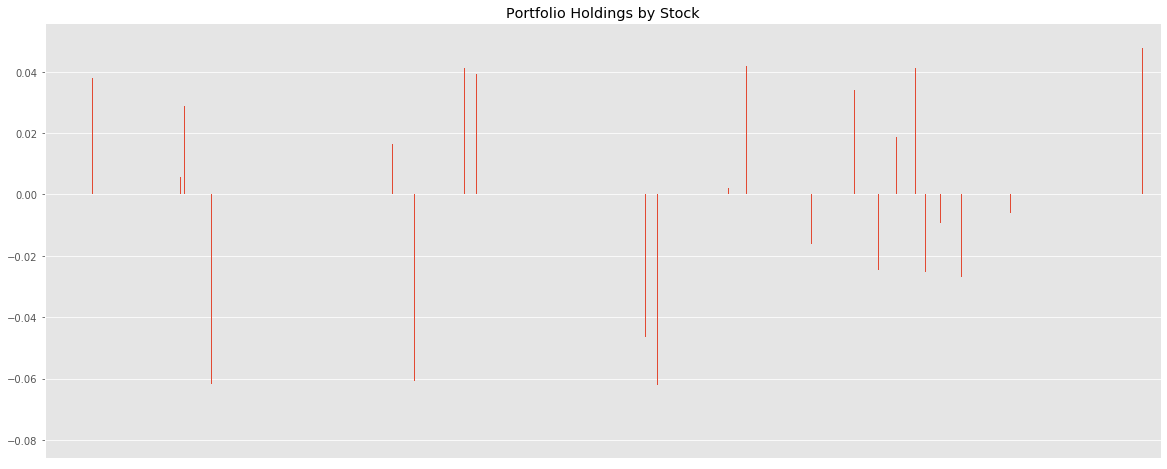

In [47]:
figsize(20, 8)
optimal_weights.plot.bar(legend=None, title='Portfolio Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [ ]:
optimal_weights.head()

# Optimize with a Regularization Parameter

In [49]:
oh = OptimalHoldingsCVX(risk_model, alpha_vector, initial_weights.values, lambda_reg=5.0)
optimal_weights = oh.find()

this is S:
[[0.0212315  0.         0.         ... 0.         0.         0.        ]
 [0.         0.03581077 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00755124 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.03765301 0.         0.        ]
 [0.         0.         0.         ... 0.         0.01334663 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00886007]]
QuadForm([[-0.03639662 -0.030869   -0.03564221 ... -0.04069411 -0.04221971
  -0.02252618]
 [-0.01868864 -0.06829516 -0.00380112 ... -0.03005601 -0.0044745
  -0.01232065]
 [ 0.00291575  0.02039562  0.00931311 ...  0.00586831  0.00660069
  -0.09210928]
 ...
 [ 0.01323771  0.03092718 -0.01496277 ...  0.04470702 -0.02477886
  -0.0117992 ]
 [ 0.0291462   0.06816249  0.01911115 ...  0.02333025  0.02389723
  -0.01193544]
 [-0.00095548 -0.05588499 -0.0023602  ... -0.05513893 -0.028823
  -0.01284779]] * var51601, [[18.79228599  0.          0.      


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.573e-16  -2.640e+03  +1e+06  8e-01  7e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -7.927e+01  -3.960e+02  +2e+05  6e-02  9e-02  2e-01  1e-01  0.9890  1e-01   2  2  2 |  0  0
 2  -1.348e+01  -5.028e+01  +2e+04  7e-03  1e-02  2e-02  2e-02  0.8944  2e-02   3  2  2 |  0  0
 3  -3.080e+00  -8.577e+00  +3e+03  1e-03  2e-03  4e-03  2e-03  0.9436  9e-02   5  4  4 |  0  0
 4  -1.441e+00  -2.304e+00  +5e+02  2e-04  2e-04  5e-04  4e-04  0.8351  9e-03   8  7  8 |  0  0
 5  -1.137e+00  -1.217e+00  +4e+01  1e-05  2e-05  7e-05  4e-05  0.9405  3e-02   1  1  1 |  0  0
 6  -1.077e+00  -1.084e+00  +3e+00  1e-06  1e-06  5e-06  3e-06  0.9409  2e-02   3  3  2 |  0  0
 7  -1.072e+00  -1.073e+00  +3e-01  1e-07  1e-07  4e-07  2e-07  0.9505  4e-02   2  1  2 |  0  0
 8  -1.072e+00  -1.072e+00  +7e-02  3e-08  3e-

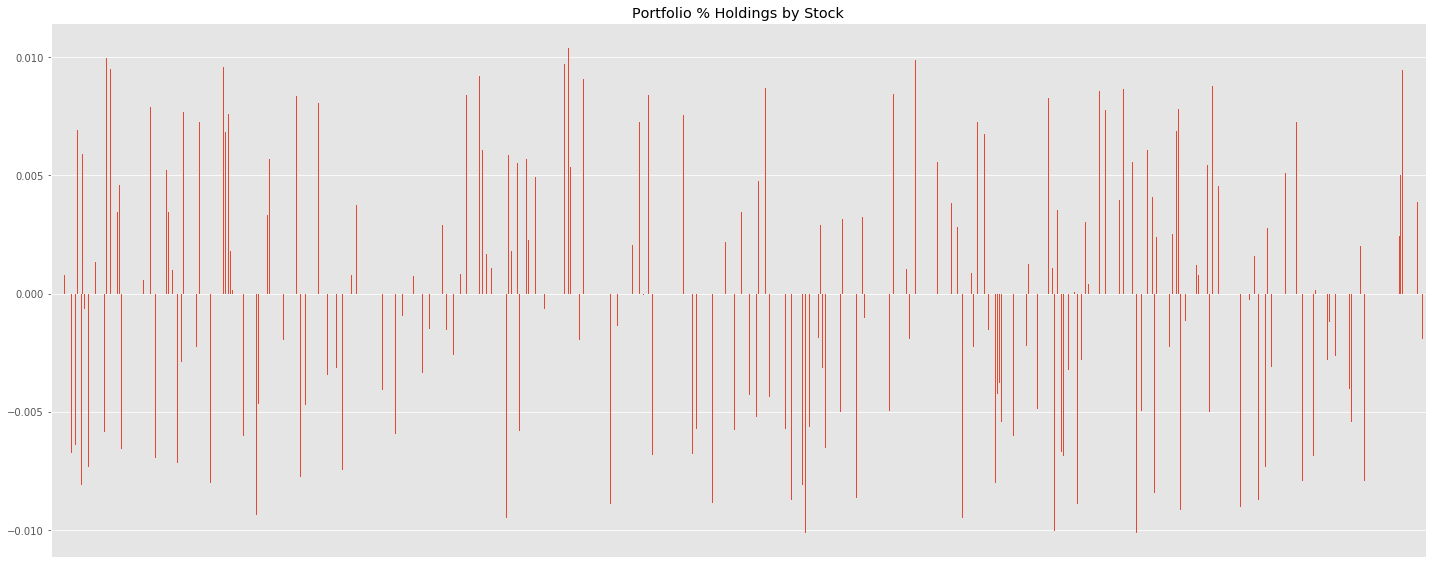

In [53]:
figsize(20, 8)
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.tight_layout()

In [52]:
optimal_weights

,0
asset,
CSCO,-1.072390e-13
UAL,4.638624e-14
TROW,2.590433e-14
ISRG,1.885414e-14
NVR,9.122376e-14
PRGO,7.088510e-03
LECO,-4.957980e-15
TPR,7.934349e-04
DVN,-3.874549e-14


# Cleaned up cvxpy optimization

In [83]:
class OptimalHoldingsCVXClean:

    def __init__(self, risk_model, alpha_vector, previous, risk_cap=0.05, factor_max=10.0, aum=50e6, lambda_reg=0.00,
                 factor_min=-10.0, weights_max=0.55, weights_min=-0.55, risk_aversion=1.0e-6):

        self.risk_model = risk_model
        self.alpha_vector = alpha_vector
        self.previous = previous
        self.risk_cap = risk_cap
        self.factor_min = factor_min 
        self.factor_max = factor_max
        self.weights_min = weights_min
        self.weights_max = weights_max
        self.risk_aversion = risk_aversion
        self.aum = aum
        self.lambda_reg = lambda_reg

    def _get_obj(self, h1):
        ra = self.risk_aversion
        Q = self.risk_model.Q # Q is k x N
        ivv = self.risk_model.i_var_vector
        av = -self.alpha_vector
        #h0 = self.previous.flatten()
        #lv = np.ones((len(av), 1)) * 0.1/2000000
        #obj_func = cvx.Minimize(np.array(av.T) * h1 + self.lambda_reg * cvx.norm(h1, 2) + (h1-h0)**2 @ lv)
        obj_func = cvx.Minimize(np.array(av.T) * h1 + self.lambda_reg * cvx.norm(h1, 2))
        
        return obj_func

    def _get_constraints(self, h1, risk):
        c = []
        factor_exposures = self.risk_model.factor_exposures
        c.append(risk <= self.risk_cap**2)
        c.append(factor_exposures.T @ h1 <= self.factor_max)
        c.append(factor_exposures.T @ h1 >= self.factor_min)
        c.append(sum(h1) == 0)
        c.append(sum(cvx.abs(h1)) <= 1.0)
        c.append(h1 >= self.weights_min)
        c.append(h1 <= self.weights_max)
        return c

    def get_risk(self, h1):
        av_index = self.alpha_vector.index
        ivm = self.risk_model.i_var_matrix.loc[av_index].values
        f = self.risk_model.factor_exposures.loc[av_index].values.T @ h1
        X = self.risk_model.factor_cov_matrix
        risk = cvx.quad_form(f, X) + cvx.quad_form(h1, ivm)
        return risk

    def find(self):
        h1 = cvx.Variable(len(self.alpha_vector))
        risk = self.get_risk(h1)
        obj_func = self._get_obj(h1)
        constraints = self._get_constraints(h1, risk)
        prob = cvx.Problem(obj_func, constraints)
        prob.solve(max_iters=100, verbose=True)
        optimal_weights = np.asarray(h1.value).flatten()
        df = pd.DataFrame(optimal_weights, index=self.alpha_vector.index)
        return df

In [84]:
oh = OptimalHoldingsCVXClean(risk_model, alpha_vector, initial_weights.values, lambda_reg=5.0)
optimal_weights = oh.find()


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.573e-16  -2.640e+03  +1e+06  8e-01  7e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -7.927e+01  -3.960e+02  +2e+05  6e-02  9e-02  2e-01  1e-01  0.9890  1e-01   2  2  2 |  0  0
 2  -1.348e+01  -5.028e+01  +2e+04  7e-03  1e-02  2e-02  2e-02  0.8944  2e-02   3  2  2 |  0  0
 3  -3.080e+00  -8.577e+00  +3e+03  1e-03  2e-03  4e-03  2e-03  0.9436  9e-02   5  4  4 |  0  0
 4  -1.441e+00  -2.304e+00  +5e+02  2e-04  2e-04  5e-04  4e-04  0.8351  9e-03   8  7  8 |  0  0
 5  -1.137e+00  -1.217e+00  +4e+01  1e-05  2e-05  7e-05  4e-05  0.9405  3e-02   1  1  1 |  0  0
 6  -1.077e+00  -1.084e+00  +3e+00  1e-06  1e-06  5e-06  3e-06  0.9409  2e-02   3  3  2 |  0  0
 7  -1.072e+00  -1.073e+00  +3e-01  1e-07  1e-07  4e-07  2e-07  0.9505  4e-02   2  1  2 |  0  0
 8  -1.072e+00  -1.072e+00  +7e-02  3e-08  3e-

In [85]:
optimal_weights.var()

0    0.000009
dtype: float64

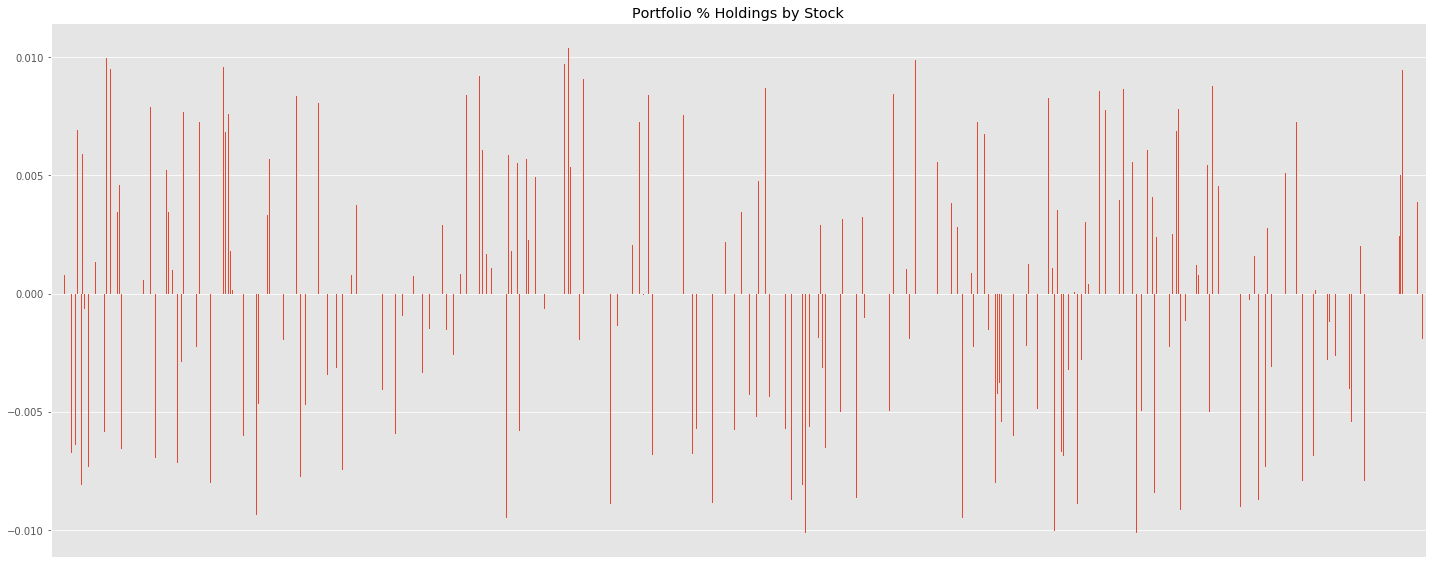

In [86]:
figsize(20, 8)
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.tight_layout()